# **Loan Default Prediction**

----------------------------------------
## **Context and Objective**
----------------------------------------

- It is very critical to be able to identify the loan defaults in the financial domain. Given a set of features about a person, the goal is to predict if the person will default or not.
- In this notebook, we are continuing to cover the concepts of LVC 3 and try to create a model that predicts if a particular person will default or not.

--------------------
## **Dataset**
--------------------

The dataset used has the below features:

- **Default** - Yes/No, categorical dependent variable suggesting the state of default.
- **Student** - Yes/No, categorical independent variable depicting if the applicant is a student or not.
- **Balance** - The account balance of the applicant.
- **Income** - The income of the applicant.

## **Importing the libraries and overview of the dataset**

In [1]:
# Used for data manipulation
import pandas as pd

# Used for numerical computations
import numpy as np

from sklearn import linear_model

# Used for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

# To get rid of warning messages
import warnings
warnings.filterwarnings('ignore') 

# Remove scientific notations and display numbers with 2 decimal points instead
pd.options.display.float_format = '{:,.2f}'.format        

# Update default background style of plots
sns.set_style(style='darkgrid')

### **Loading the data**

In [2]:
# Let us import the files
df = pd.read_csv('data/Default.csv', index_col=0)

In [3]:
# View the head of the data frame
df.head()

,default,student,balance,income
1,No,No,729.53,"44,361.63"
2,No,Yes,817.18,"12,106.13"
3,No,No,"1,073.55","31,767.14"
4,No,No,529.25,"35,704.49"
5,No,No,785.66,"38,463.50"


### **Encoding categorical variables**

In [4]:
# Let us define a dictionary to replace the Yes/No with 1/0
encoding_dict = {'Yes': 1, 'No': 0}

In [5]:
# Encoding the features
df['default'] = df['default'].map(encoding_dict)
df['student'] = df['student'].map(encoding_dict)

In [6]:
# Creating the independent variables
X = df.drop('default', axis = 1)

# Target variable
Y = df['default']

In [7]:
# Instantiating the scaler
ss = StandardScaler()

X = ss.fit_transform(X)

## **K-Nearest Neighbors from Scratch**

When we implement KNN algorithm using sklearn library, we find its K-Nearest Neighbors for each record in the training set, **including the point itself**, and classify by majority vote. In particular, when K=1, the record only looks at itself and always gets it right, and train error is zero. For the records in the test set, we find the K-Nearest Neighbors in the training set (thus, these are different than the record being tested), and classify by majority vote.

> Due to this difference between classification in training and testing data, we can try to do the same thing on the entire  dataset, **without leaving out a test set**, i.e., for each record in the entire data set, we find the K-Nearest Neighbors (**other than itself**), and classify by majority vote.

To do this, we will need to code the algorithm from scratch. The below code creates a class called KNearestNeighbor with different methods like train(), predict(). We have shown different ways to computer distances between data points. Invoking the predict() by specifying the data and num_loops will compute the distances and return respective predictions.

**Step-wise implementation of KNN from scratch**

1. Instantiating the K-Nearest Neighbor

2. Setting the training data using the train() method

3. Invoking the predict() by specifying the data and num_loops. It will compute the distances and return respective predictions.

In [8]:
"""
Implementation of K-nearest neighbor (KNN) from scratch
where you can either use 2-loops (inefficient), 1-loop (better)
or a heavily vectorized zero-loop implementation.
"""

import numpy as np

class KNearestNeighbor:
    def __init__(self, k):
        self.k = k

    def train(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X_test, num_loops=0, train=True):
        if num_loops == 0:
            distances = self.compute_distance_vectorized(X_test)
        elif num_loops == 1:
            distances = self.compute_distance_one_loop(X_test)
        else:
            distances = self.compute_distance_two_loops(X_test)
        return self.predict_labels(distances, train)

    def compute_distance_two_loops(self, X_test):
        """
        Inefficient naive implementation, use only
        as a way of understanding what kNN is doing
        """
        num_test = X_test.shape[0]
        num_train = self.X_train.shape[0]
        distances = np.zeros((num_test, num_train))

        for i in range(num_test):
            for j in range(num_train):
                distances[i, j] = np.sqrt(np.sum((X_test[i, :] - self.X_train[j, :])**2))
                
        return distances

    def compute_distance_one_loop(self, X_test):
        """
        Much better than two-loops but not as fast as fully vectorized version.
        Utilize Numpy broadcasting in X_train - X_test[i,:]
        """
        num_test = X_test.shape[0]
        num_train = self.X_train.shape[0]
        distances = np.zeros((num_test, num_train))

        for i in range(num_test):
            distances[i, :] = np.sqrt(np.sum((self.X_train - X_test[i, :])** 2, axis=1))

        return distances

    def compute_distance_vectorized(self, X_test):
        """
        Can be tricky to understand this, we utilize heavy
        vectorization as well as numpy broadcasting.
        Idea: if we have two vectors a, b (two examples)
        and for vectors we can compute (a-b)^2 = a^2 - 2a (dot) b + b^2
        expanding on this and doing so for every vector lends to the 
        heavy vectorized formula for all examples at the same time.
        """
        X_test_squared = np.sum(X_test ** 2, axis=1, keepdims=True)
        X_train_squared = np.sum(self.X_train ** 2, axis=1, keepdims=True)
        two_X_test_X_train = np.dot(X_test, self.X_train.T)

        return np.sqrt(
            self.eps + X_test_squared - 2 * two_X_test_X_train + X_train_squared.T
        )

    def predict_labels(self, distances, train):
        num_test = distances.shape[0]
        y_pred = np.zeros(num_test)

        for i in range(num_test):
            y_indices = np.argsort(distances[i, :])
            if train==True:
                k_closest_classes = self.y_train[y_indices[1:self.k+1]].astype(int)
            elif train==False:
                k_closest_classes = self.y_train[y_indices[:self.k]].astype(int)
            y_pred[i] = np.argmax(np.bincount(k_closest_classes))

        return y_pred

In [9]:
# Converting into an array
X_array = np.array(X)
y_array = np.array(Y)
X_array[:5], y_array[:5]

(array([[-0.64593619, -0.21883482,  0.81318727],
        [ 1.54814054, -0.03761593, -1.60549572],
        [-0.64593619,  0.49241019, -0.13121225],
        [-0.64593619, -0.6328925 ,  0.16403093],
        [-0.64593619, -0.10279088,  0.37091513]]),
 array([0, 0, 0, 0, 0], dtype=int64))

In [10]:
# We select the best value of K for which the error rate is the least
# Let us loop over a few values of K to determine the best value
knn_many_split = {}

for n_neighbors in range(1, 200):
    lista = []
    
    # Fitting the KNN with k = n_neighbors
    KNN = KNearestNeighbor(k = n_neighbors)
    
    # Fitting the model on the data
    KNN.train(X_array, y_array)
    
    # Making predictions on the data using trained model
    y_pred = KNN.predict(X_array, num_loops=1, train = True)
    lista.append(1 - (sum(y_pred == y_array) / y_array.shape[0]))
    knn_many_split[n_neighbors] = lista
    
    print(f'k {n_neighbors:>3}: {np.round(lista[0], 4):>8}')

knn_many_split

k   1:   0.0419
k   2:   0.0338
k   3:   0.0339
k   4:   0.0305
k   5:   0.0322
k   6:   0.0294
k   7:    0.029
k   8:   0.0278
k   9:   0.0288
k  10:   0.0277
k  11:   0.0281
k  12:   0.0281
k  13:   0.0277
k  14:   0.0275
k  15:   0.0278
k  16:   0.0278
k  17:   0.0276
k  18:   0.0281
k  19:   0.0276
k  20:   0.0279
k  21:   0.0276
k  22:   0.0278
k  23:   0.0274
k  24:   0.0278
k  25:   0.0274
k  26:   0.0278
k  27:   0.0278
k  28:   0.0281
k  29:   0.0274
k  30:   0.0278
k  31:   0.0275
k  32:   0.0276
k  33:   0.0274
k  34:    0.028
k  35:   0.0276
k  36:   0.0279
k  37:   0.0273
k  38:   0.0277
k  39:   0.0273
k  40:   0.0274
k  41:   0.0273
k  42:   0.0276
k  43:   0.0273
k  44:   0.0277
k  45:   0.0276
k  46:   0.0282
k  47:   0.0277
k  48:   0.0281
k  49:   0.0278
k  50:   0.0282
k  51:   0.0277
k  52:    0.028
k  53:   0.0276
k  54:   0.0278
k  55:   0.0278
k  56:   0.0279
k  57:   0.0278
k  58:   0.0277
k  59:   0.0278
k  60:   0.0279
k  61:   0.0278
k  62:   0.0277
k  63:  

{1: [0.04190000000000005],
 2: [0.03380000000000005],
 3: [0.03390000000000004],
 4: [0.03049999999999997],
 5: [0.032200000000000006],
 6: [0.02939999999999998],
 7: [0.029000000000000026],
 8: [0.027800000000000047],
 9: [0.028800000000000048],
 10: [0.027699999999999947],
 11: [0.028100000000000014],
 12: [0.028100000000000014],
 13: [0.027699999999999947],
 14: [0.02749999999999997],
 15: [0.027800000000000047],
 16: [0.027800000000000047],
 17: [0.027599999999999958],
 18: [0.028100000000000014],
 19: [0.027599999999999958],
 20: [0.027900000000000036],
 21: [0.027599999999999958],
 22: [0.027800000000000047],
 23: [0.02739999999999998],
 24: [0.027800000000000047],
 25: [0.02739999999999998],
 26: [0.027800000000000047],
 27: [0.027800000000000047],
 28: [0.028100000000000014],
 29: [0.02739999999999998],
 30: [0.027800000000000047],
 31: [0.02749999999999997],
 32: [0.027599999999999958],
 33: [0.02739999999999998],
 34: [0.028000000000000025],
 35: [0.027599999999999958],
 36: 

In [11]:
# Extracting k, the error in different lists for easy plotting
kl = [n_neighbors for n_neighbors, model_err in knn_many_split.items()]
vl = [model_err[0] for n_neighbors, model_err in knn_many_split.items()]

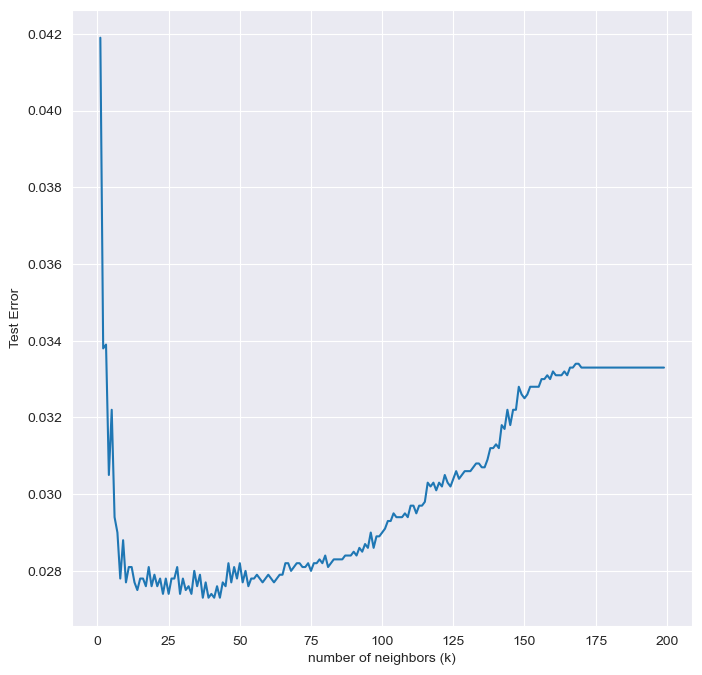

In [12]:
# Plotting k vs error
plt.figure(figsize=(8,8))
plt.plot(kl, vl)
plt.xlabel("number of neighbors (k)")
plt.ylabel("Test Error")
plt.show()

In [13]:
k_model_err = {k: v[0] for k, v in knn_many_split.items()}
print('Best model when k =', min(k_model_err, key=k_model_err.get))

37

## **Conclusion**

- The test error is changing with changing the k values.
- The value of K in the KNN method is related to the model's error rate. A small value of K may result in overfitting, whereas a large value of k may result in underfitting. Overfitting implies that the model performs well on the training data but performs poorly when additional data is introduced.
- We can observe that the test error increased with the increase in the value of K, it started growing after K crosses 70. The larger the value of K is, the smoother the classification boundary. So, we have to pick the best suitable K value by evaluating with different values of K.